In [1]:
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
using BAT 
using MultivariateStats
using Clustering
using PyPlot

# PDF:

In [2]:
Σ = [3.426818298733095 12.378238116671048 -9.632531611142456; 
    12.378238116671048 69.83909693165143 -43.478993858310886; 
    -9.632531611142456 -43.478993858310886 60.0626256206892]

μ = [8.959570984309234, -9.021529871694005, -5.007789383392622]

n_dims = 3 

distribution = MvNormal(μ, Σ)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

In [3]:
log_likelihood = let dist = distribution
    params -> begin
        LogDVal(logpdf(dist, params.x))
    end
end

posterior = PosteriorDensity(log_likelihood, prior);

In [48]:
nsamples = 3*10^5

# samples = bat_sample(
#     posterior, 
#     nsamples, MCMCSampling(sampler = MetropolisHastings(), nchains = 4)
# ).result; # MCMCSampling(sampler = MetropolisHastings(), nchains = 4)

samples = bat_sample(
    distribution, 
    nsamples, IIDSampling()).result; 

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [49]:
i_ahmi = log(bat_integrate(samples).result)

┌ Info: Using integration algorithm AHMIntegration{CholeskyPartialWhitening,GeyerAutocorLen}
│   whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
│   autocorlen: GeyerAutocorLen GeyerAutocorLen()
│   volumetype: Symbol HyperRectangle
│   max_startingIDs: Int64 10000
│   max_startingIDs_fraction: Float64 2.5
│   rect_increase: Float64 0.1
│   warning_minstartingids: Int64 16
│   dotrimming: Bool true
│   uncertainty: Array{Symbol}((1,))
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	150000 / 149999	Parameters:	3
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_

0.0024 ± 0.0025

## Functions: 

In [100]:
function find_steep_edges(smpl::AbstractArray, w::AbstractArray; α=0.01)
    hist_weights = fit(Histogram, smpl, weights(w), nbins=100).weights
    max_weight = maximum(hist_weights)
    if hist_weights[1] < α*max_weight && hist_weights[end] < α*max_weight
        return false
    else
        return true
    end
end


function find_whiten_trans(smpl::AbstractArray, w::AbstractArray; edges=zeros(Bool, size(smpl)[1]))
      
    cov_m = cov(smpl .- mean(smpl, dims=2), FrequencyWeights(w), 2)
    
    for (ind, edge) in enumerate(edges)
        if edge 
            tmp_vals = cov_m[ind,ind]
            cov_m[:,ind] .= 0.0
            cov_m[ind,:] .= 0.0
            cov_m[ind,ind] = tmp_vals
        end
    end
    
    L = eigvals(cov_m)
    E = eigvecs(cov_m)
    W = E'
    W = W ./ sqrt.(L .+ 1e-4)
    
    return(W = W,)
    
end

function apply_whiten_trans(smpl::AbstractArray, W::AbstractMatrix)
    return W*(smpl .- mean(smpl, dims=2))
end

function apply_clustering(smpl::AbstractArray, w::AbstractArray, n_clusters::Integer)
    return kmeans(smpl, n_clusters, weights=w)
end

function find_volume(smpl::AbstractArray, w::AbstractArray, ll::AbstractArray, clust_center::AbstractArray)
    size_cube = 1.
    vol = (2*size_cube)^size(smpl)[1]
    mask = prod(-size_cube .< smpl .< size_cube, dims=1 )[1,:]
    return(mask = mask, vol = vol)
end

function compute_hm(smpl::AbstractArray, w::AbstractArray, ll::AbstractArray, mask::AbstractArray, vol::AbstractFloat, det1::AbstractFloat, det2::AbstractFloat)
    r = sum(w[mask]) / sum(w) 
    x = mean(1 ./ exp.(ll[mask]), weights(w[mask]))
    i_r = vol / (x*det1*det2)
    
    return  i_r / r
end

compute_hm (generic function with 1 method)

In [111]:
smpl_v = collect(flatview(unshaped.(samples.v)))
smpl_w = samples.weight

log_d_minimum = minimum(samples.logd )
smpl_ld = samples.logd # .- log_d_minimum # subtract constant pedestal;

In [112]:
steep_edges = [find_steep_edges(row, smpl_w) for row in eachrow(smpl_v)]
whiten_trans_init = find_whiten_trans(smpl_v, smpl_w, edges=steep_edges).W
smpl_v = apply_whiten_trans(smpl_v, whiten_trans_init)

integral_estimates = Float64[]

n_clusters = 2

clusters = apply_clustering(smpl_v, smpl_w, n_clusters)

for clust_ind in 1:n_clusters
    mask_cluster = clusters.assignments .== clust_ind
    whiten_trans_tmp = find_whiten_trans(smpl_v[:,mask_cluster], smpl_w[mask_cluster], edges=steep_edges).W
    smpl_tmp = apply_whiten_trans(smpl_v, whiten_trans_tmp)

    cluster_center = whiten_trans_tmp * clusters.centers[:,clust_ind]
    mask_volume, volume = find_volume(smpl_tmp[:,mask_cluster], smpl_w[mask_cluster], smpl_ld[mask_cluster], cluster_center)
    
#     mask_cluster_t = deepcopy(mask_cluster)
    mask_cluster[mask_cluster .== 1] .= mask_volume
#     hm_estimate = compute_hm(smpl_tmp, smpl_w, smpl_ld, mask_cluster, volume, abs(det(whiten_trans_init)), abs(det(whiten_trans_tmp)))
     hm_estimate = compute_hm(smpl_tmp, smpl_w, smpl_ld, mask_cluster, volume, abs(det(whiten_trans_tmp*whiten_trans_init)), 1.0)
    
    hm_estimate = log(hm_estimate) #+ log_d_minimum
    push!(integral_estimates, hm_estimate)
end



In [113]:
integral_estimates

2-element Array{Float64,1}:
 0.6964348500550176
 0.6940299610541482

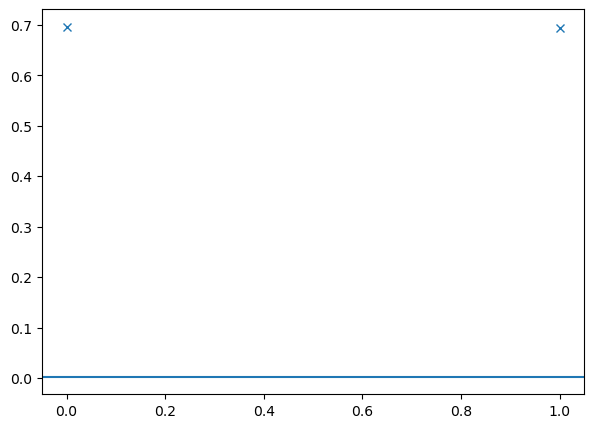

PyObject <matplotlib.lines.Line2D object at 0x7fcf524faf40>

In [114]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(integral_estimates, "x")
ax.axhline([i_ahmi.val])